# Reproduce: Orlando et al., Phys. Rev. B 60, 15398 (1999)

J. R. Johansson, http://jrjohansson.github.com, <robert@riken.jp>

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
from wavefunction.wavefunction2d import *

## Introduction

Here we reproduce some of the numerical results from Orlando et al., PRB 60, 15398 (1999).

We numerically calculate the wavefunctions and energy-levels of the flux device using the two-dimensional potential of the superconducting flux-qubit circuit. The two generalized coordinates are the gauge invariant phases across the Josephson junctions in the device.

The numerics is programmed in Python and uses the [wavefunction](http://github.com/jrjohansson/wavefunction) Python package. For details of how the eigenvalue problem is written on matrix form using a Fourier series decomposition, see the documentation for the wavefunction package.

# Original coordinates

The Hamiltonian in the original phase coordinates is [from Eq. (11) in Orlando et al.]

$H_t = 
\frac{1}{2} P^T M^{-1} P + E_J(2 + \alpha - \cos\varphi_1 - \cos\varphi_2 - \alpha\cos(2\pi f + \varphi_1 - \varphi_2))$

where $P = (-i\hbar\partial_{\varphi_1}, -i\hbar\partial_{\varphi_2})^T$ is the generalized momentum vector and the mass matrix is

$M = (\Phi_0/2\pi)^2 C \begin{pmatrix} 1 + \alpha + \gamma & -\alpha \\ -\alpha & 1 + \alpha + \gamma\end{pmatrix}$

and

$M^{-1} = \frac{1}{(\Phi_0/2\pi)^2 C} \frac{1}{(1 + \gamma)(1 + \gamma + 2\alpha)}
 \begin{pmatrix} 1 + \alpha + \gamma & \alpha \\ \alpha & 1 + \alpha + \gamma\end{pmatrix}$

This gives

$H_t =
\frac{4E_C }{(1 + \gamma)(1 + \gamma + 2\alpha)}
\left[
(1 + \gamma + \alpha)\left(\frac{\partial}{\partial\varphi_1}\right)^2 +
2\alpha\frac{\partial}{\partial\varphi_1}\frac{\partial}{\partial\varphi_2} +
(1 + \gamma + \alpha)\left(\frac{\partial}{\partial\varphi_2}\right)^2
\right]
 + E_J(2 + \alpha - \cos\varphi_1 - \cos\varphi_2 - \alpha\cos(2\pi f + \varphi_1 - \varphi_2))$


For the numerical calculations we use units of $E_J$.

### Parameters

In [4]:
args = {'Ec': 1/80.0, 'Ej': 1.0, 'alpha': 0.8, 'gamma': 0.0, 'f': 0.50}

In [5]:
globals().update(args)

### Assembling the matrix for the kinetic contribution

The kinetic part of the Hamiltonian is

$T = -\frac{4}{(1 + \gamma)(1 + \gamma + 2\alpha)}\frac{E_C}{E_J} \left[ (1 + \gamma + \alpha)\left(\frac{\partial}{\partial\varphi_1}\right)^2 + 2\alpha\frac{\partial}{\partial\varphi_1}\frac{\partial}{\partial\varphi_2} + (1 + \gamma + \alpha)\left(\frac{\partial}{\partial\varphi_2}\right)^2 \right]$

and we need to write it in the Fourier series basis on the form (see the documentation of the wavefunction package for details)

$\displaystyle K_{n_1, n_2}^{m_1, m_2} = \delta_{n_1,m_1} \delta_{n_2,m_2}
\left(k_{11}\left(\frac{2\pi m_1}{T_{x_1}}\right)^2 + k_{12}\frac{(2\pi)^2 m_1m_2}{T_{x_1}T_{x_2}} + k_{22}\left(\frac{2\pi m_2}{T_{x_2}}\right)^2\right)$

so we can identify

$k_{11} = k_{22} = 4 \frac{E_C}{E_J} \frac{1 + \alpha + \gamma}{(1 + \gamma)(1 + 2\alpha + \gamma}$

$k_{12} = 4 \frac{E_C}{E_J} \frac{2\alpha}{(1 + \gamma)(1 + 2\alpha + \gamma}$

In [6]:
# pick a truncation of the fourier series: n1 = [-L1, ..., L1], n2 = [-L2, ..., L2]
L1 = 10
L2 = 10

# pick periods for the coordinates
Tx1 = Tx2 = 2 * np.pi

#
k11 = k22 = 4 * (Ec / Ej) * (1 + alpha + gamma) / ((1 + gamma) * (1 + 2 * alpha + gamma))
k12 = 4 * (Ec / Ej) * 2 * alpha / ((1 + gamma) * (1 + 2 * alpha + gamma))

In [7]:
K = assemble_K(L1, L2, k11, k12, k22, Tx1, Tx2)

### Assembling the matrix for the potential contribution

The flux qubit potential we consider here is

$\displaystyle U(\varphi_1, \varphi_2)/E_J = 2 + \alpha - \cos(\varphi_1) - \cos(\varphi_2) - \alpha \cos(2\pi f + \varphi_1 - \varphi_2)$

To obtain the Fourier series expansion of $U(\varphi_1, \varphi_2)$, we first write the $\cos$ expressions as exponential functions

$\displaystyle U(\varphi_1, \varphi_2)/E_J = (2 + \alpha) 
- \frac{1}{2}(e^{i\varphi_1} + e^{-i\varphi_1})
- \frac{1}{2}(e^{i\varphi_2} + e^{-\varphi_2})
- \alpha\frac{1}{2}(e^{i2\pi f}e^{i\varphi_1}e^{-i\varphi_2} + e^{-i2\pi f}e^{-i\varphi_1}e^{i\varphi_2})$

$\displaystyle U(\varphi_1, \varphi_2)/E_J = \sum_{n_1}\sum_{n_2} u_{n_1n_2} e^{in_1\varphi_1}e^{in_2\varphi_2}$

we can identity

$\displaystyle u_{n_1n_2} = (2 + \alpha) \delta_{0,n_1}\delta_{0,n_2} 
- \frac{1}{2}(\delta_{1, n_1} + \delta_{-1, n_1})\delta_{0,n_2} 
- \frac{1}{2}(\delta_{1, n_2} + \delta_{-1, n_2})\delta_{0,n_1}
- \frac{\alpha}{2} (e^{i2\pi f} \delta_{1,n_1}\delta_{-1,n_2} + e^{-i2\pi f}\delta_{-1,n_1}\delta_{+1,n_2}) $

In [8]:
def U_flux_qubit(x1, x2, args):
    globals().update(args)
    return 2 + alpha - np.cos(x1) - np.cos(x2) - alpha * np.cos(2 * np.pi * f + x1 - x2)

In [9]:
def assemble_u_flux_qubit(L1, L2, args, sparse=False):

    globals().update(args)
    
    L1n = 2 * L1 + 1
    L2n = 2 * L2 + 1
    
    u = np.zeros((L1n, L2n), dtype=np.complex)
    
    for n1 in np.arange(-L1, L1+1):
        N1 = n1 + L1
        for n2 in np.arange(-L2, L2+1):
            N2 = n2 + L2
            u[N1, N2] = (2 + alpha) * delta(0, n1) * delta(0, n2) + \
                        - 0.5 * (delta(1, n1) + delta(-1, n1)) * delta(0, n2) + \
                        - 0.5 * (delta(1, n2) + delta(-1, n2)) * delta(0, n1)+ \
                        - 0.5 * alpha * np.exp(+2j * np.pi * f) * delta(+1, n1) * delta(-1, n2) + \
                        - 0.5 * alpha * np.exp(-2j * np.pi * f) * delta(-1, n1) * delta(+1, n2)                    
    return u

In [10]:
u = assemble_u_flux_qubit(L1, L2, args)

### Check: Evaluate and plot the Fourier series representation of the flux qubit potential and compare to original function

In [11]:
x1 = np.linspace(-2*np.pi, 2*np.pi, 100)
x2 = np.linspace(-2*np.pi, 2*np.pi, 100)
X1, X2 = np.meshgrid(x1, x2)

In [12]:
U1 = U_flux_qubit(X1, X2, args)

In [13]:
U2 = evalute_fourier_series(X1, X2, L1, L2, u)

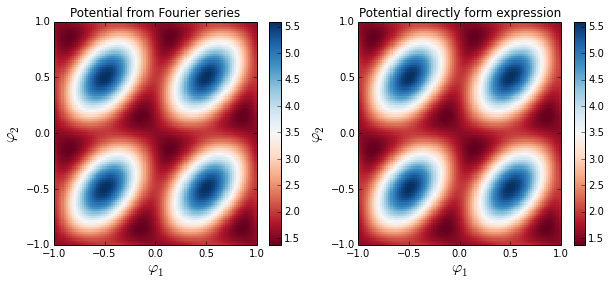

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# reconstructed
Z = np.real(U2)
p = axes[0].pcolor(X1/(2*np.pi), X2/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
cb = fig.colorbar(p, ax=axes[0])
axes[0].set_xlabel(r'$\varphi_1$', fontsize=16)
axes[0].set_ylabel(r'$\varphi_2$', fontsize=16)
axes[0].set_title('Potential from Fourier series')

# original
Z = np.real(U1)
p = axes[1].pcolor(X1/(2*np.pi), X2/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
axes[1].set_xlabel(r'$\varphi_1$', fontsize=16)
axes[1].set_ylabel(r'$\varphi_2$', fontsize=16)
cb = fig.colorbar(p, ax=axes[1])
axes[1].set_title('Potential directly form expression');

### Potential contribution to the eigenvalue problem

Given this Fourier series we can calcuate the potential contribution to the eigenvalue problem as


$\displaystyle V_{n_1, n_2}^{m_1, m_2} = u_{n_1-m_1,n_2-m_2}$

In [15]:
V = assemble_V(L1, L2, u)

and specifically for the flux qubit potential we can calculate this contribution analytically

$\displaystyle V_{n_1, n_2}^{m_1, m_2} = (2 + \alpha) \delta_{0,n_1-m_1}\delta_{0,n_2-m_2} 
- \frac{1}{2}(\delta_{1, n_1-m_1} + \delta_{-1, n_1-m_1})\delta_{0,n_2-m_2} 
- \frac{1}{2}(\delta_{1, n_2-m_2} + \delta_{-1, n_2-m_2})\delta_{0,n_1-m_1}
- \frac{\alpha}{2} (e^{i2\pi f} \delta_{1,n_1-m_1}\delta_{-1,n_2-m_2} + e^{-i2\pi f}\delta_{-1,n_1-m_1}\delta_{+1,n_2-m_2}) $

In [16]:
def assemble_V_flux_qubit(L1, L2, args, sparse=False):
    
    globals().update(args)
    
    L1n = 2 * L1 + 1
    L2n = 2 * L2 + 1
    
    V = np.zeros((L1n*L1n, L2n*L2n), dtype=np.complex)
    
    for n1 in np.arange(-L1, L1+1):
        for n2 in np.arange(-L1, L1+1):
            N = index_m2v(L1, n1, n2)
            for m1 in np.arange(-L2, L2+1):
                for m2 in np.arange(-L2, L2+1):
                    M = index_m2v(L2, m1, m2)

                    V[N,M] = (2 + alpha) * delta(m1, n1) * delta(m2, n2) + \
                             - 0.5 * (delta(m1 + 1, n1) + delta(m1 - 1, n1)) * delta(m2, n2) + \
                             - 0.5 * (delta(m2 + 1, n2) + delta(m2 - 1, n2)) * delta(m1, n1) + \
                             - 0.5 * alpha * np.exp(+2j * np.pi * f) * delta(m1 + 1, n1) * delta(m2 - 1, n2) + \
                             - 0.5 * alpha * np.exp(-2j * np.pi * f) * delta(m1 - 1, n1) * delta(m2 + 1, n2)

    return V

In [17]:
V_fq = assemble_V_flux_qubit(L1, L2, args)

Check: Make sure that both methods give the same $V$:

In [18]:
abs(V - V_fq).max()

0.0

## Solving the eigenvalue problem

We now want to solve the eigenvalue problem

$H \Psi = E \Psi$

where $H$ is the matrix representation of the Hamiltonian assembled from $K$ and $V$ above.

In [19]:
H = K + V

In [20]:
vals, vecs = solve_eigenproblem(H)

### Plot energy levels and potential at $f=0.5$

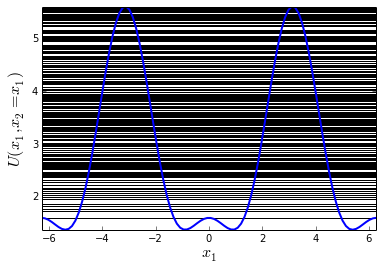

In [21]:
fig, ax = plt.subplots()

U_x = np.real(U_flux_qubit(x1, -x1, args))

for val in vals:
    ax.plot(x1, np.real(val) * np.ones_like(x1), 'k')

ax.plot(x1, U_x, label="potential", lw='2')
    
ax.axis('tight')
ax.set_ylim(min(vals[0], U_x.min()), U_x.max())
ax.set_ylabel(r'$U(x_1, x_2=x_1)$', fontsize=16)
ax.set_xlabel(r'$x_1$', fontsize=16);

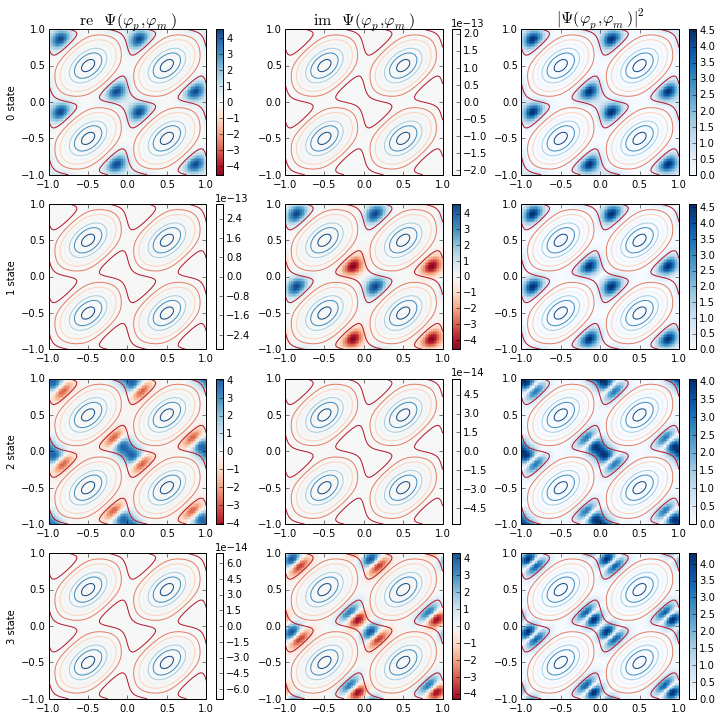

In [22]:
Nstates = 4

fig, axes = plt.subplots(Nstates, 3, figsize=(12, 3 * Nstates))

for n in range(Nstates):

    psi = convert_v2m(L1, L2, vecs[n])
    
    Z = np.real(evalute_fourier_series(X1, X2, L1, L2, u))
    PSI = evalute_fourier_series(X1, X2, L1, L2, psi)
    
    p = axes[n, 0].pcolor(X1/(2*np.pi), X2/(2*np.pi), np.real(PSI),
                          cmap=cm.RdBu, vmin=-abs(PSI.real).max(), vmax=abs(PSI.real).max())
    c = axes[n, 0].contour(X1/(2*np.pi), X2/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n, 0])
    cb.set_clim(-5, 5)

    p = axes[n, 1].pcolor(X1/(2*np.pi), X2/(2*np.pi), np.imag(PSI),
                          cmap=cm.RdBu, vmin=-abs(PSI.imag).max(), vmax=abs(PSI.imag).max())
    c = axes[n, 1].contour(X1/(2*np.pi), X2/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n, 1])
    cb.set_clim(-5, 5)
    
    p = axes[n, 2].pcolor(X1/(2*np.pi), X2/(2*np.pi), np.abs(PSI), cmap=cm.Blues, vmin=0, vmax=abs(PSI).max())
    c = axes[n, 2].contour(X1/(2*np.pi), X2/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n, 2])

    axes[n, 0].set_ylabel("%d state" % n);

axes[0, 0].set_title(r"$\mathrm{re}\;\Psi(\varphi_p, \varphi_m)$", fontsize=16);
axes[0, 1].set_title(r"$\mathrm{im}\;\Psi(\varphi_p, \varphi_m)$", fontsize=16);
axes[0, 2].set_title(r"$|\Psi(\varphi_p, \varphi_m)|^2$", fontsize=16);

### Plot the energy levels as a function of $f$: Fig 4(a) in Orlando et al.

In [23]:
f_vec = np.linspace(0.47, 0.50, 50)
e_vals = np.zeros((len(vals), len(f_vec)))

In [24]:
K = assemble_K(L1, L2, k11, k12, k22, Tx1, Tx2)

for f_idx, f in enumerate(f_vec):
    args['f'] = f
    #u = assemble_u_flux_qubit(L1, L2, args)
    #V = assemble_V(L1, L2, u)
    V = assemble_V_flux_qubit(L1, L2, args)
    H = K + V
    vals, vecs = solve_eigenproblem(H)
    
    e_vals[:, f_idx] = np.real(vals)

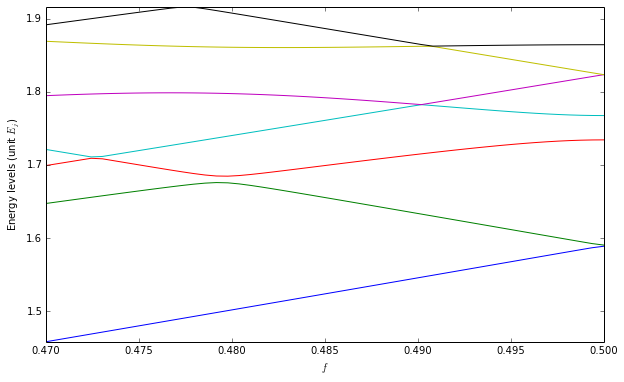

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

for n in range(len(vals)):
    ax.plot(f_vec, e_vals[n, :])

ax.axis('tight')

ax.set_ylim(e_vals[0, :].min(), e_vals[6, :].max())

ax.set_ylabel(r'Energy levels (unit $E_j$)')
ax.set_xlabel(r'$f$');

### Circulating currents in ground and excited state at $f=0.49$

In [26]:
args['f'] = 0.49
K = assemble_K(L1, L2, k11, k12, k22, Tx1, Tx2)
V = assemble_V_flux_qubit(L1, L2, args)    
H = K + V
vals, vecs = solve_eigenproblem(H)

In [27]:
# current operator for junction 1
I1 = np.sin(X1)

# current operator for junction 2
I2 = np.sin(X2)

In [28]:
# ground and excited state wave functions
psi0 = wavefunction_normalize(X1, X2, evalute_fourier_series(X1, X2, L1, L2, convert_v2m(L1, L2, vecs[0])))
psi1 = wavefunction_normalize(X1, X2, evalute_fourier_series(X1, X2, L1, L2, convert_v2m(L1, L2, vecs[1])))

In [29]:
expectation_value(X1, X2, I1, psi0).real  # I1/Ic

-0.6970801175708653

In [30]:
expectation_value(X1, X2, I1, psi1).real  # I2/Ic

0.695251761312768

These circulating currents are given as $I_{1,2} = \pm0.70 I_c$ in Orlando et al.

# Rotated coordinates

The same problem can also be solved in a rotated coordinate system. The Hamiltonian in the rotated coordinates, where $\phi_p = (\phi_1 + \phi_2)/2$ and $\phi_m = (\phi_1 - \phi_2)/2$, is [Ex. (12) in Orlando et al.]

$H_t = \frac{1}{2M_p}\left(-i\hbar\frac{\partial}{\partial\phi_p}\right)^2 + \frac{1}{2M_m}\left(-i\hbar\frac{\partial}{\partial\phi_m}\right)^2 + E_J(2 + \alpha - 2 \cos\phi_p\cos\phi_m - \alpha\cos(2\pi f + 2 \phi_m))$

where

$M_p = \left(\frac{\Phi_0}{2\pi}\right)^2 2 C(1 + \gamma),$

$M_m = \left(\frac{\Phi_0}{2\pi}\right)^2 2 C(1 + 2\alpha + \gamma).$

For the numerical calculations we use units of $E_J$

$H_t = -\frac{2}{1 + \gamma}\frac{E_C}{E_J}\left(\frac{\partial}{\partial\phi_p}\right)^2 
- \frac{2}{1 + 2\alpha + \gamma}\frac{E_C}{E_J}\left(\frac{\partial}{\partial\phi_m}\right)^2 + (2 + \alpha - 2 \cos\phi_p\cos\phi_m - \alpha\cos(2\pi f + 2 \phi_m))$


### Parameters

In [31]:
args = {'Ec': 1/80.0, 'Ej': 1.0, 'alpha': 0.8, 'gamma': 0.02, 'f': 0.50}

### Assembling the matrix for the kinetic contribution

The kinetic part of the Hamiltonian can be written on the form

$\displaystyle K_{n_1, n_2}^{m_1, m_2} = \delta_{n_1,m_1} \delta_{n_2,m_2}
\left(k_{11}\left(\frac{2\pi m_1}{T_{x_1}}\right)^2 + k_{12}\frac{(2\pi)^2 m_1m_2}{T_{x_1}T_{x_2}} + k_{22}\left(\frac{2\pi m_2}{T_{x_2}}\right)^2\right)$

with

$k_{11} = \frac{2}{1 + \gamma}\frac{E_C}{E_J}$

$k_{12} = 0$

$k_{22} = \frac{2}{1 + 2\alpha + \gamma}\frac{E_C}{E_J}$

In [32]:
# pick a truncation of the fourier series: n1 = [-L1, ..., L1], n2 = [-L2, ..., L2]
L1 = 10
L2 = 10

# pick periods for the coordinates
Tx1 = Tx2 = 2 * np.pi

#
k11, k12, k22 = 2 / (1 + gamma) * Ec / Ej, 0.0, 2 / (1 + 2 * alpha + gamma) * Ec / Ej

In [33]:
K = assemble_K(L1, L2, k11, k12, k22, Tx1, Tx2)

### Assembling the matrix for the potential contribution

The flux qubit potential we consider here is

$\displaystyle U(x_p, x_m) = 2 + \alpha - 2 \cos\phi_p\cos\phi_m - \alpha\cos(2\pi f + 2 \phi_m)$

To obtain the Fourier series expansion of $U(x_p, x_m)$, we first write the $\cos$ expressions as exponential functions

$\displaystyle U(x_p, x_m) = 2 + \alpha
- \frac{1}{2}(e^{ix_p}e^{ix_m} + e^{ix_p}e^{-ix_m} + e^{-ix_p}e^{ix_m} + e^{-ix_p}e^{-ix_m})
- \alpha\frac{1}{2}(e^{i2\pi f}e^{i2x_m} + e^{-i2\pi f}e^{-i2x_m})$

Now, by comparing with the Fourier series

$\displaystyle U(x_p, x_m) = \sum_{n_1}\sum_{n_2} u_{n_1n_2} e^{in_1x_p}e^{in_2x_m}$

we can identity

$\displaystyle u_{n_1n_2} = (2 + \alpha) \delta_{0,n_1}\delta_{0,n_2} 
- 
\frac{1}{2}
(
\delta_{1, n_1}\delta_{1, n_2} + 
\delta_{1, n_1}\delta_{-1,n_2} + 
\delta_{-1, n_1}\delta_{1,n_2} + 
\delta_{-1, n_1}\delta_{-1,n_2}
)
- 
\frac{\alpha}{2} (e^{i2\pi f} \delta_{0,n_1}\delta_{+2,n_2} + e^{-i2\pi f}\delta_{0,n_1}\delta_{-2,n_2}) $

### Fourier series decomposition of flux qubit potential

In [34]:
def assemble_u_flux_qubit(L1, L2, args, sparse=False):

    globals().update(args)
    
    L1n = 2 * L1 + 1
    L2n = 2 * L2 + 1
    
    u = np.zeros((L1n, L2n), dtype=np.complex)

    u[L1, L2] = 2 + alpha

    u[+1+L1, +1+L2] = - 0.5
    u[-1+L1, +1+L2] = - 0.5
    u[+1+L1, -1+L2] = - 0.5
    u[-1+L1, -1+L2] = - 0.5

    u[L1, +2+L2] = -0.5 * alpha * np.exp(+2j * np.pi * f)
    u[L1, -2+L2] = -0.5 * alpha * np.exp(-2j * np.pi * f)

    return u

In [35]:
u = assemble_u_flux_qubit(L1, L2, args)

### Check: Evaluate and plot the Fourier series representation of the flux qubit potential and compare to direct evaluation

In [36]:
phi_p = np.linspace(-1*np.pi, 1*np.pi, 100)
phi_m = np.linspace(-1*np.pi, 1*np.pi, 100)
PHI_P, PHI_M = np.meshgrid(phi_p, phi_m)

In [37]:
def U_flux_qubit(phi_p, phi_m, args):
    globals().update(args)
    return 2 + alpha - 2 * np.cos(phi_p) * np.cos(phi_m) - alpha * np.cos(2 * np.pi * f + 2 * phi_m)

In [38]:
U1 = U_flux_qubit(PHI_P, PHI_M, args)

In [39]:
U2 = evalute_fourier_series(PHI_P, PHI_M, L1, L2, u)

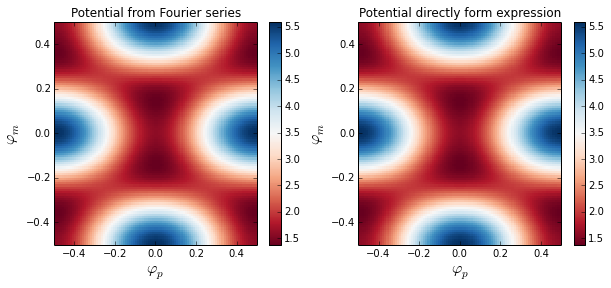

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# reconstructed
Z = np.real(U2)
p = axes[0].pcolor(PHI_P/(2*np.pi), PHI_M/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
cb = fig.colorbar(p, ax=axes[0])
axes[0].axis('tight')
axes[0].set_xlabel(r'$\varphi_p$', fontsize=16)
axes[0].set_ylabel(r'$\varphi_m$', fontsize=16)
axes[0].set_title('Potential from Fourier series')

# original
Z = np.real(U1)
p = axes[1].pcolor(PHI_P/(2*np.pi), PHI_M/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
cb = fig.colorbar(p, ax=axes[1])
axes[1].set_xlabel(r'$\varphi_p$', fontsize=16)
axes[1].set_ylabel(r'$\varphi_m$', fontsize=16)
axes[1].axis('tight')
axes[1].set_title('Potential directly form expression');

### Potential contribution to the eigenvalue problem

Given this Fourier series we can calcuate the potential contribution to the eigenvalue problem as


$\displaystyle V_{n_1, n_2}^{m_1, m_2} = u_{n_1-m_1,n_2-m_2}$

In [41]:
V_full = assemble_V(L1, L2, u)

and specifically for the flux qubit potential

$\displaystyle  V_{n_1, n_2}^{m_1, m_2} = (2 + \alpha) \delta_{0,n_1-m_1}\delta_{0,n_2-m_2} 
- 
\frac{1}{2}
(
\delta_{1, n_1-m_1}\delta_{1, n_2-m_2} + 
\delta_{1, n_1-m_1}\delta_{-1,n_2-m_2} + 
\delta_{-1, n_1-m_1}\delta_{1,n_2-m_2} + 
\delta_{-1, n_1-m_1}\delta_{-1,n_2-m_2}
)
- 
\frac{\alpha}{2} (e^{i2\pi f} \delta_{0,n_1-m_1}\delta_{+2,n_2-m_2} + e^{-i2\pi f}\delta_{0,n_1-m_1}\delta_{-2,n_2-m_2}) $

In [42]:
def assemble_V_flux_qubit(L1, L2, args, sparse=False):
    
    globals().update(args)
    
    L1n = 2 * L1 + 1
    L2n = 2 * L2 + 1
    
    V = np.zeros((L1n*L1n, L2n*L2n), dtype=np.complex)
    
    for n1 in np.arange(-L1, L1+1):
        for n2 in np.arange(-L1, L1+1):
            N = index_m2v(L1, n1, n2)
            for m1 in np.arange(-L2, L2+1):
                for m2 in np.arange(-L2, L2+1):
                    M = index_m2v(L2, m1, m2)

                    V[N,M] = (2 + alpha) * delta(m1, n1) * delta(m2, n2) + \
                             - 0.5 * (delta(m1 + 1, n1) * delta(m2 + 1, n2) + 
                                      delta(m1 + 1, n1) * delta(m2 - 1, n2) + 
                                      delta(m1 - 1, n1) * delta(m2 + 1, n2) + 
                                      delta(m1 - 1, n1) * delta(m2 - 1, n2)) + \
                             - 0.5 * alpha * np.exp(+2j * np.pi * f) * delta(m1, n1) * delta(m2 + 2, n2) + \
                             - 0.5 * alpha * np.exp(-2j * np.pi * f) * delta(m1, n1) * delta(m2 - 2, n2)

    return V

In [43]:
V = assemble_V_flux_qubit(L1, L2, args)

Check that both methods give the same results:

In [44]:
abs(V-V_full).max()

0.0

## Solving the eigenvalue problem

We now want to solve the eigenvalue problem

$H \Psi = E \Psi$

where $H$ is the matrix representation of the Hamiltonian assembled from $K$ and $V$ above.

In [45]:
H = K + V

In [46]:
vals, vecs = solve_eigenproblem(H)

### Plot eigenenergies and the potential along $x_p=0$ line 

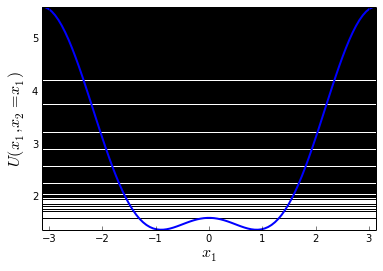

In [47]:
fig, ax = plt.subplots()

U_x = np.real(U_flux_qubit(0, phi_m, args))

for val in vals:
    ax.plot(phi_m, np.real(val) * np.ones_like(phi_m), 'k')

ax.plot(phi_m, U_x, label="potential", lw='2')
    
ax.axis('tight')
ax.set_ylim(min(vals[0], U_x.min()), U_x.max())
ax.set_ylabel(r'$U(x_1, x_2=x_1)$', fontsize=16)
ax.set_xlabel(r'$x_1$', fontsize=16);

### Plot the wavefunctions for the lowest few eigenstates

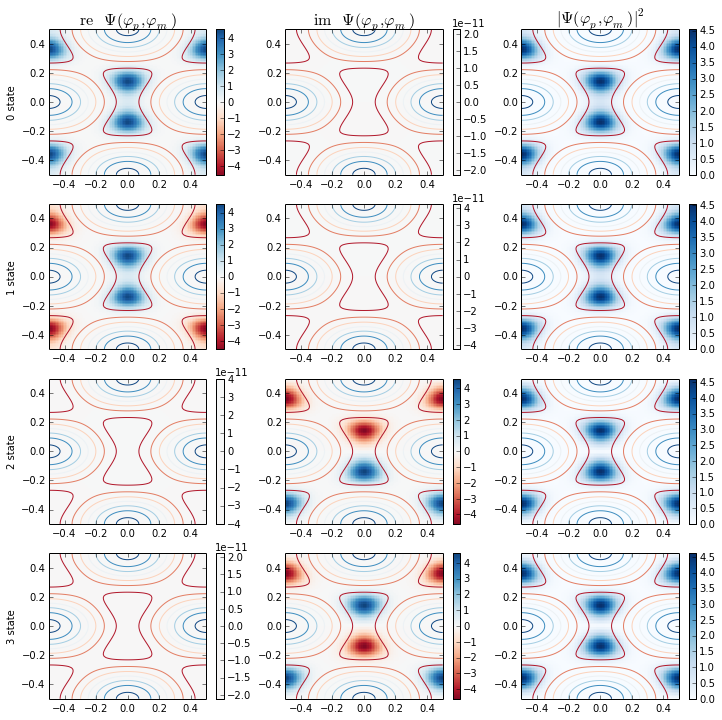

In [48]:
Nstates = 4

fig, axes = plt.subplots(Nstates, 3, figsize=(12, 3 * Nstates))

for n in range(Nstates):

    psi = convert_v2m(L1, L2, vecs[n])
    
    Z = np.real(evalute_fourier_series(PHI_P, PHI_M, L1, L2, u))
    PSI = evalute_fourier_series(PHI_P, PHI_M, L1, L2, psi)
    
    p = axes[n, 0].pcolor(PHI_P/(2*np.pi), PHI_M/(2*np.pi), np.real(PSI),
                          cmap=cm.RdBu, vmin=-abs(PSI.real).max(), vmax=abs(PSI.real).max())
    c = axes[n, 0].contour(PHI_P/(2*np.pi), PHI_M/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n, 0])
    cb.set_clim(-5, 5)

    p = axes[n, 1].pcolor(PHI_P/(2*np.pi), PHI_M/(2*np.pi), np.imag(PSI),
                          cmap=cm.RdBu, vmin=-abs(PSI.imag).max(), vmax=abs(PSI.imag).max())
    c = axes[n, 1].contour(PHI_P/(2*np.pi), PHI_M/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n, 1])
    cb.set_clim(-5, 5)
    
    p = axes[n, 2].pcolor(PHI_P/(2*np.pi), PHI_M/(2*np.pi), np.abs(PSI), cmap=cm.Blues, vmin=0, vmax=abs(PSI).max())
    c = axes[n, 2].contour(PHI_P/(2*np.pi), PHI_M/(2*np.pi), Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = fig.colorbar(p, ax=axes[n, 2])

    axes[n, 0].set_ylabel("%d state" % n);

axes[0, 0].set_title(r"$\mathrm{re}\;\Psi(\varphi_p, \varphi_m)$", fontsize=16);
axes[0, 1].set_title(r"$\mathrm{im}\;\Psi(\varphi_p, \varphi_m)$", fontsize=16);
axes[0, 2].set_title(r"$|\Psi(\varphi_p, \varphi_m)|^2$", fontsize=16);

### Energy levels as a function applied flux: Fig. 4(a) in Orlando et al.

In [49]:
f_vec = np.linspace(0.47, 0.5, 25)

e_vals = np.zeros((len(vals), len(f_vec)))

In [50]:
K = assemble_K(L1, L2, k11, k12, k22, Tx1, Tx2)

for f_idx, f in enumerate(f_vec):
    args['f'] = f
    V = assemble_V_flux_qubit(L1, L2, args)
    H = K + V
    vals, vecs = solve_eigenproblem(H)
    
    e_vals[:, f_idx] = np.real(vals)

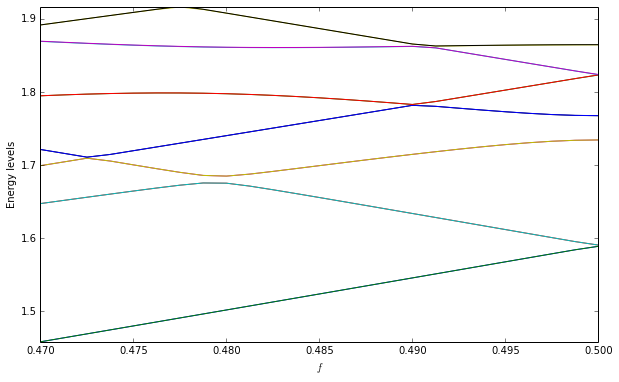

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

for n in range(len(vals)):
    ax.plot(f_vec, e_vals[n, :])

ax.axis('tight')

ax.set_ylim(e_vals[0, :].min(), e_vals[12, :].max())

ax.set_ylabel("Energy levels")
ax.set_xlabel(r'$f$');

### Circulating currents in ground and excited state at $f=0.49$

In [52]:
args['f'] = 0.49
K = assemble_K(L1, L2, k11, k12, k22, Tx1, Tx2)
V = assemble_V_flux_qubit(L1, L2, args)    
H = K + V
vals, vecs = solve_eigenproblem(H)

In [53]:
# current operator for junction 1
I1 = np.sin(PHI_P + PHI_M)

# current operator for junction 2
I2 = np.sin(PHI_P - PHI_M)

In [54]:
# ground and excited state wave functions
psi0 = wavefunction_normalize(PHI_P, PHI_M, evalute_fourier_series(PHI_P, PHI_M, L1, L2, convert_v2m(L1, L2, vecs[0])))
psi1 = wavefunction_normalize(PHI_P, PHI_M, evalute_fourier_series(PHI_P, PHI_M, L1, L2, convert_v2m(L1, L2, vecs[1])))

In [55]:
expectation_value(PHI_P, PHI_M, I1, psi0).real  # I1/Ic

-0.70154983812794125

In [56]:
expectation_value(PHI_P, PHI_M, I2, psi0).real  # I2/Ic

0.70154983812794169

These circulating currents are given as $I_{1,2} = \pm0.70 I_c$ in Orlando et al.

## Software versions

In [57]:
%reload_ext version_information
%version_information numpy, scipy, matplotlib, wavefunction

Software versions
Python 3.3.1 (default, Apr 17 2013, 22:30:32) [GCC 4.7.3]
IPython 2.0.0-dev
OS posix [linux]
numpy 1.7.1
scipy 0.13.0.dev-ab773bf
matplotlib 1.4.x
wavefunction 1.0.0

Thu Aug 29 11:23:58 2013 JST